# Difference Target Propagation
---
In this notebook, we will use an interesting neural network that learns via **target propagation** to classify images from the CIFAR-10 database. Note that we provide a number of instructions (including code and descriptions) for the ease of your learning. Be free to change the provided code if you want but in this case you should explain your motivation in the submitted report.


Our aim is to reproduce the results of the paper entitled "Difference Target Propagation" （ https://arxiv.org/abs/1412.7525 ） on the CIFAR-10 database. Before completing this work, you are required to carefully read the paper and understand its basic idea about the proposed learning strategy. 


![](model.png)

Figure 1. The Schematic overview of the target propagation


### Test for CUDA

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Load the Data

If you're not familiar with the Cifar-10, you may find it useful to look at: http://www.cs.toronto.edu/~kriz/cifar.html . 

A copy of the data is also placed on the class website.  

#### TODO: Load the data

In [2]:
# 图象变换和正则化
transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
# 载入数据
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=20,shuffle=True,num_workers=2)
testset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=20,shuffle=True,num_workers=2)
# 定义类别信息
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


---
## Define the Network Architecture

Here, you'll define a neural network named DTPNet, whose architecture resembles multiple layer perceptron (MLP) but adopts target propagation for parameter updating. You may use the following Pytorch functions to build it.

* [Linear transformation layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
* [Non-linear activations](https://pytorch.org/docs/stable/generated/torch.tanh.html)
* [Gradient computing operation](https://pytorch.org/docs/stable/autograd.html?highlight=torch%20autograd%20grad#torch.autograd.grad)


### TODO: 
#### 1)  Define DTPNet: Completing the __init__ function
**Sizes of the hidden layers**: As the MLP takes a vector as input (ignoring the dimension of the batch), we should transform the image to a vector, whose dimension should be 3072 ($ 32\times 32\times 3 $)。 We suggest that the network architecture was 3072-1000-1000-1000-10. In each layer, the network uses the hyperbolic tangent as the activation function. You can also design these hyperparameters on your own.

 HINT: because we will compute the loss and gradient for each layer instead of chain rule, you might want to build a separate computational graph for each layer. Think of how to do this.#### 2)  Define the forward path of DTPNet: Completing the "forward" function
The forward path involves computing unit values for all layers, that is,

\begin{align}
\text{for } i&=  \text{1 to } M \\
 & h_i \leftarrow f_i(h_{i-1})
\end{align}
where $f_i$ stands for the transformation layer of the DTPNet. Please refer to the original paper for more information.

#### 3)  Define the backward path of DTPNet: Completing the "backward" function
The computational details of the backward path are described in Algorithm 1 of the paper. It involves computing the targets, calculating the loss and calculate the gradients for each of the layers in the neural network in a top-down manner. 

To make the code more readable, you need first define the "backward" function will call ``compute_target`` and ``reconstruction`` function.

**Important:** The basic idea of the strategy to update the parameter for each layer are presented in the following section. You may need it for completing this function.

##### 3.1)  Calculate the targets for each layer
For the target of the highest layer, it is computed by
$\hat{\mathbf{h}}_{M-1} \leftarrow \mathbf{h}_{M-1} - \hat{\eta} \frac {\partial L} {\partial \mathbf{h}_{M-1}}$, \; ($L$ is the global loss)

For the targets of the lower layers, they are computed by
\begin{align}
\text{for } i&=  M-1 \text{ to } 2 \\
& \hat{\mathbf{h}}_{i-1} \leftarrow \mathbf{h}_{i-1} - g_i(\mathbf{h}_{i}) +  g_i(\hat{\mathbf{h}}_{i})
\end{align}


##### 3.2) Implement the reconstruction function 
The reconstruction function involves $g_i(f_i(\mathbf{h}_{i-1}))$.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DTPNet(nn.Module):
    def __init__(self,hidden_sizes = None):
        super(DTPNet, self).__init__()
        self.hidden_sizes=hidden_sizes
        wf = nn.ModuleList([])
        wb = nn.ModuleList([])

        for i in range(len(self.hidden_sizes) - 1):
            wf.append(nn.Linear(self.hidden_sizes[i], self.hidden_sizes[i + 1])) # 根据输入定义正向传播层

        for i in range(len(self.hidden_sizes) - 2):
            wb.append(nn.Linear(self.hidden_sizes[-1 - i], self.hidden_sizes[-2 - i])) # 根据输入定义反向传播层
        
        self.logsoft = nn.LogSoftmax(dim=1)
        self.wf = wf
        self.wb = wb

    def forward(self, x):
        self.x=x
        values = [x]
        for i in range(len(self.hidden_sizes) - 2):
            values.append(torch.tanh(self.wf[i](values[i])))
        values.append(self.logsoft(self.wf[-1](values[-1])))
        return values
    
    # 根据global_loss计算target
    def compute_target(self, values,global_loss):
        targets=[]
        grad = torch.autograd.grad(global_loss, values[3],retain_graph = True)
        target2=values[3]-0.5*grad[0]
        target1=values[2] - torch.tanh(self.wb[1](values[3])) + torch.tanh(self.wb[1](target2))
        target0=values[1] - torch.tanh(self.wb[2](values[2])) + torch.tanh(self.wb[2](target1))
    
        targets.append(target0)
        targets.append(target1)
        targets.append(target2)
        
        return targets 

    # 为方便计算，将backward放在主函数中实现

    # 为方便计算，为reconstruct添加了一个参数i，方便分别计算每层的reconstruction
    def reconstruct(self,values,i):
        reconstructions=torch.tanh(self.wb[3-i](torch.tanh(self.wf[i](values))))
        return reconstructions
        
model = DTPNet([3072,1000,1000,1000,10])
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

DTPNet(
  (logsoft): LogSoftmax(dim=1)
  (wf): ModuleList(
    (0): Linear(in_features=3072, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=1000, bias=True)
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): Linear(in_features=1000, out_features=10, bias=True)
  )
  (wb): ModuleList(
    (0): Linear(in_features=10, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=1000, bias=True)
    (2): Linear(in_features=1000, out_features=1000, bias=True)
  )
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) 

Before the training process, you need to first specify your the loss function. For example, we set the negative log-likelihood as the the global loss of the image classification task. 

#### TODO: Define the loss

In [4]:
nlll = nn.NLLLoss()
mse = torch.nn.MSELoss(reduction='sum')

---
## Train the Network
The details of the training phrase of DTPNet can be found in Algorithm 1 of the paper, which is also posted here for your convenience.  Please note that the training process of DTPNet is dramatically different from the traditional neural network. The main difference is that back-propagation uses chain rule to update parameters and the DTP calculates the targets and updates parameters layer by layer. Thus, so you can use the "detach" function in Pytorch to truncate the gradients to avoid auto-differetiation.

Hint: Instead using the backpropagation algorithm, we calculate the loss and then calculate the gradients for each layer, then we can use the gradients for each layer to update the parameters for each layer.
## Examples to show how to update parameters of a single layer by Pytorch
There are two approaches to derive the gradients for the parameters of a neural network, namely, the optimizer module and autograd.grad() function. You can choose one of them or both of them to accomplish this work. Below, we will elaborate them in detail.
### 1)  Optimizer
The ``optimizer`` module controls the parameter updating for the neural network in Pytorch. We take a single layer of the multiple layer perceptron (MLP) as an example, which is defined by
```
single_layer = torch.nn.Linear(2,3)
```
We can build an optimizer via Pytorch.
```
optimizer = torch.optim.RMSprop([{'params':single_layer.parameters(), 'lr': 1}])
```
Then we can update the parameters of single_layer by calling the ``step`` function of the optimizer, for example,
```
x = torch.randn(10,2)
y = torch.randn(10,3)
predict = single_layer(x)
loss = ((predict-y)**2).sum() 
loss.backward()
optimizer.step()
```



### 2) autograd.grad()
This function provides a way for the users to manually obtain the gradients for each of the parameters.
```
x = torch.randn(10,2)
y = torch.randn(10,3)
predict = MLP(x)
loss = ((predict-y)**2).sum()
grad_weight = torch.autograd.grad(loss, MLP.weight, retain_graph = True)[0]

```



<img src="algo.png" alt="drawing" width="800"/>



Remember to look at how the training and validation loss decreases over time and print them.

In [17]:
lr=0.01

#每个SGD均对单层求梯度
optimizer_wf0=torch.optim.SGD(model.wf[0].parameters(),lr=lr)
optimizer_wf1=torch.optim.SGD(model.wf[1].parameters(),lr=lr)
optimizer_wf2=torch.optim.SGD(model.wf[2].parameters(),lr=lr)
optimizer_wf_top = torch.optim.SGD(model.wf[3].parameters(), lr=lr)

optimizer_wb0 = torch.optim.SGD(model.wb[0].parameters(),lr=lr)
optimizer_wb1 = torch.optim.SGD(model.wb[1].parameters(),lr=lr)
optimizer_wb2 = torch.optim.SGD(model.wb[2].parameters(),lr=lr)

In [18]:
from torch.autograd import Variable
from torch.autograd import grad
# train
for epoch in range(250):
    correct=0.0 # 输出打印需要的参数
    running_loss=0.0
    for i,data in enumerate(trainloader):
        inputs,labels=data
        inputs=Variable(inputs)
        labels=Variable(labels)
        # forward pass
        inputs=inputs.reshape(20,3072)

        if train_on_gpu:
            inputs=inputs.type(torch.cuda.FloatTensor)
            labels=labels.type(torch.cuda.FloatTensor).long()

        values=model(inputs)

        global_loss=nlll(values[4],labels) # 计算global_loss

        target=model.compute_target(values,global_loss) # 计算target
        target[0]=Variable(target[0],requires_grad=False)
        target[1]=Variable(target[0],requires_grad=False)
        target[2]=Variable(target[0],requires_grad=False)
        
        # 反向层的梯度归零
        optimizer_wb0.zero_grad()
        optimizer_wb1.zero_grad()
        optimizer_wb2.zero_grad()
        
        # 分别反向计算每层的grad并更新
        values_corrupt0=values[3]+0.01*torch.randn_like(values[3])
        reconstruction0=model.reconstruct(values_corrupt0,3)
        loss_wb0=mse(values_corrupt0, reconstruction0)/(2*inputs.size(0))
        pp0=torch.autograd.grad(loss_wb0,model.wb[0].weight)[0].detach()
        model.wb[0].weight.grad=pp0
        optimizer_wb0.step()
        
        values_corrupt1=values[2]+0.01*torch.randn_like(values[2])
        reconstruction1=model.reconstruct(values_corrupt1,2)
        loss_wb1=mse(values_corrupt1, reconstruction1)/(2*inputs.size(0))
        pp0=torch.autograd.grad(loss_wb1,model.wb[1].weight)[0].detach()
        model.wb[1].weight.grad=pp0
        optimizer_wb1.step()
        
        
        values_corrupt2=values[1]+0.01*torch.randn_like(values[1])
        reconstruction2=model.reconstruct(values_corrupt2,1)
        loss_wb2=mse(values_corrupt2, reconstruction2)/(2*inputs.size(0))
        pp0=torch.autograd.grad(loss_wb2,model.wb[2].weight)[0].detach()
        model.wb[2].weight.grad=pp0
        optimizer_wb2.step()

        # 前向传播梯度归零
        optimizer_wf0.zero_grad()
        optimizer_wf1.zero_grad()
        optimizer_wf2.zero_grad()
        optimizer_wf_top.zero_grad()

        # 分别前向计算每层的grad并更新
        loss_wf0=mse(torch.tanh(model.wf[0](values[0])), target[0])/(2*inputs.size(0))
        pp0=torch.autograd.grad(loss_wf0,model.wf[0].weight)[0].detach()
        model.wf[0].weight.grad=pp0
        optimizer_wf0.step()
        
        loss_wf1=mse(torch.tanh(model.wf[1](values[1])), target[1])/(2*inputs.size(0))
        pp0=torch.autograd.grad(loss_wf1,model.wf[1].weight)[0].detach()
        model.wf[1].weight.grad=pp0
        optimizer_wf1.step()
        
        loss_wf2=mse(torch.tanh(model.wf[2](values[2])), target[2])/(2*inputs.size(0))
        pp0=torch.autograd.grad(loss_wf2,model.wf[2].weight)[0].detach()
        model.wf[2].weight.grad=pp0
        optimizer_wf2.step()

        loss_wf_top = nlll(values[-1].float(), labels).mean()
        pp0=torch.autograd.grad(loss_wf_top,model.wf[3].weight)[0].detach()
        model.wf[3].weight.grad=pp0
        optimizer_wf_top.step()
        
        # 对计算过程进行计算
        pred = values[-1].data.max(1, keepdim=True)[1]
        correct+=pred.eq(labels.data.view_as(pred)).cpu().sum()

        # 每1000次打印global_loss
        running_loss+=global_loss.item()
        if i%1000 ==999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    
    # 每个epoch打印训练集准确率
    print('\nAverage Training Error Rate: {:.2f}% ({}/{})\n'.format(100*(len(trainloader.dataset)- correct.item() )/ len(trainloader.dataset), 
                    len(trainloader.dataset)-correct.item(), len(trainloader.dataset)))
        
        
        

[1,  1000] loss: 0.403
[1,  2000] loss: 0.425

Average Training Error Rate: 11.56% (5782.0/50000)

[2,  1000] loss: 0.400
[2,  2000] loss: 0.415

Average Training Error Rate: 11.56% (5779.0/50000)

[3,  1000] loss: 0.387
[3,  2000] loss: 0.414

Average Training Error Rate: 11.24% (5618.0/50000)

[4,  1000] loss: 0.378
[4,  2000] loss: 0.403

Average Training Error Rate: 10.80% (5398.0/50000)

[5,  1000] loss: 0.371
[5,  2000] loss: 0.393

Average Training Error Rate: 10.58% (5288.0/50000)



KeyboardInterrupt: 

---
## Test the Trained Network

Test your trained model on previously unseen data and print the test accuracy of each class and the whole! Try your best to get a better accuracy.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


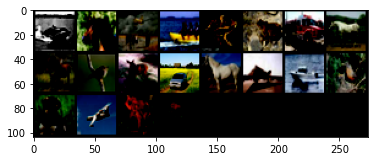

GroundTruth:   ship horse plane  ship  frog  frog truck horse  deer  bird  deer   car horse plane  ship  bird   dog plane  frog  deer


In [19]:
import matplotlib.pyplot as plt 

# 读取20张图片
dataiter=iter(testloader) 
images,labels=dataiter.next()
img=torchvision.utils.make_grid(images).numpy()
plt.imshow(np.transpose(img,(1,2,0)))
plt.show()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(20)))

In [20]:
# 用模型预测四张图片
images=Variable(images)
if train_on_gpu:
    images=images.type(torch.cuda.FloatTensor)
images=images.reshape(20,3072)
outputs=model(images)
_,predicted=torch.max(outputs[4].data,1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(20)))

Predicted:   ship horse  bird  ship  frog  frog truck horse  deer  bird   dog  deer horse truck plane  deer  bird plane  frog  deer


In [21]:
# 用模型对整个测试集测试，得出正确率
correct=0
total=0
for data in testloader:
    images,labels=data

    images=Variable(images)
    if train_on_gpu:
        images=images.type(torch.cuda.FloatTensor)
        labels=labels.type(torch.cuda.FloatTensor).long()
    images=images.reshape(20,3072)
    outputs=model(images)
    _,predicted=torch.max(outputs[4].data,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct // total))

Accuracy of the network on the 10000 test images: 48 %


In [22]:
# 测试每一类的正确率
class_correct = list(0. for i in range(10)) 
class_total = list(0. for i in range(10))
for data in testloader:    
    images, labels = data

    images=Variable(images)
    if train_on_gpu:
        images=images.type(torch.cuda.FloatTensor)
        labels=labels.type(torch.cuda.FloatTensor).long()
    images=images.reshape(20,3072)
    outputs = model(images)
    _, predicted = torch.max(outputs[4].data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):  
        label = labels[i] 
        class_correct[label] += c[i]
        class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 52 %
Accuracy of  bird : 38 %
Accuracy of   cat : 20 %
Accuracy of  deer : 31 %
Accuracy of   dog : 39 %
Accuracy of  frog : 64 %
Accuracy of horse : 52 %
Accuracy of  ship : 61 %
Accuracy of truck : 53 %


### Question: What are your model's weaknesses during your experiment and how might they be improved?

与CNN同样的问题，对于动物尤其是鸟和猫分类的准确率较低，可能需要更好的结构解决这个问题。
网络整体计算速度与收敛速度较慢，在训练了数百个epoch后，效果还不如普通的CNN效果好。由于算力与时间原因，并未尝试更多的epoch。但计算速度是网络本身结构所导致的，对每层分别更新导致其计算与收敛速度必然会慢一些，想要达到理想的准确率也必然需要更多的训练。
其它问题将在报告中说明。